# Zillow Zestimate Competition 2017
## Linear regression algorithm attempt

In [1]:
import numpy as np #arrays and matrices
import pandas as pd #data analysis
import matplotlib.pyplot as plt #plotting and visualizations
import pprint as pp #tidying up dictionaries (in our case)

%matplotlib inline 
#make the matplotlib graphs show in the notebook
import gc #garbage collection, for memory management

In [2]:
pd.options.display.float_format = '{:,.4f}'.format

### Bring In The Data

In [3]:
train_df_raw= pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"]) #need the file to be in the same directory level as this notebook file
prop = pd.read_csv("properties_2016.csv") #, usecols=good_import_cols) #the properties of each house, where each house is known as parcelid in the data

C:\Users\board\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Remove and Impute Nulls
##### Impute = "assign (a value) to something by inference from the value of the products or processes to which it contributes."

In [4]:

train_df_merged = train_df_raw.merge(prop, on='parcelid', how = 'left')

missing_df = train_df_merged.isnull().sum(axis=0).reset_index() # Finds the number of missing values per column in property file and reset index for the next operation

missing_df.columns = ['column_name', 'missing_count'] # Assign names for the only 2 columns

missing_df = missing_df.loc[missing_df['missing_count']>0] # Remove any features that have no empty rows aka any columns completely filled
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df_merged.shape[0] # Create new column for ratio of empties
missing_df_over75 = missing_df.loc[missing_df['missing_ratio']>0.75] # Remove any with less than 75% vals missing
print(missing_df.sort_values('missing_count', ascending=False)) # Printed to compare the cols that were dropped by the last action
missing_df_over75.sort_values('missing_count', ascending=False)

                     column_name  missing_count  missing_ratio
8            buildingclasstypeid          90259         0.9998
15          finishedsquarefeet13          90242         0.9996
5                   basementsqft          90232         0.9995
43                   storytypeid          90232         0.9995
48            yardbuildingsqft26          90180         0.9989
51                 fireplaceflag          90053         0.9975
4       architecturalstyletypeid          90014         0.9971
45        typeconstructiontypeid          89976         0.9967
18           finishedsquarefeet6          89854         0.9953
11                    decktypeid          89617         0.9927
30                   poolsizesum          89306         0.9893
31                  pooltypeid10          89114         0.9871
32                   pooltypeid2          89071         0.9867
57            taxdelinquencyflag          88492         0.9802
58            taxdelinquencyyear          88492        

,column_name,missing_count,missing_ratio
8,buildingclasstypeid,90259,0.9998
15,finishedsquarefeet13,90242,0.9996
5,basementsqft,90232,0.9995
43,storytypeid,90232,0.9995
48,yardbuildingsqft26,90180,0.9989
51,fireplaceflag,90053,0.9975
4,architecturalstyletypeid,90014,0.9971
45,typeconstructiontypeid,89976,0.9967
18,finishedsquarefeet6,89854,0.9953
11,decktypeid,89617,0.9927


In [5]:
train_df_merged.shape

(90275, 60)

We see here that some number of cols were dropped by our limit of 75% missing vals. Let's see exactly how many.

In [6]:
print("Total num of variables: ",train_df_merged.shape[1])
print("Total num of vars w/ all values: ", train_df_merged.drop(missing_df.column_name,axis=1).shape[1])
print("Total num of variables with at least 1 missing value: ", missing_df.shape[0], "\n\
Total num of variables w/ at least 1 missing value while also missing at least 75% of its observations: ", missing_df_over75.shape[0]) 
# The shape of the two tuples
print("Total num of variables missing less than 75% of its observations:",missing_df.shape[0] - missing_df_over75.shape[0]) # The num of vars with less than 75% of missing vals

Total num of variables:  60
Total num of vars w/ all values:  13
Total num of variables with at least 1 missing value:  47 
Total num of variables w/ at least 1 missing value while also missing at least 75% of its observations:  25
Total num of variables missing less than 75% of its observations: 22


In [7]:
# Make parcel id the index 
train_df_merged.index = train_df_merged.parcelid

In [8]:
train_df_dropna = train_df_merged.drop(missing_df_over75.column_name.tolist(), axis = 1) # Remove the cols with > 75% missing vals
train_df_dropna = train_df_dropna.drop(['parcelid'],axis = 1)
train_df_dropna # The remaing NaN vals are where data is missing

,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,2016-01-01,1.0000,2.0000,3.0000,4.0000,2.0000,"1,684.0000","1,684.0000","6,037.0000",...,"96,370.0000",0.0000,1.0000,"1,959.0000","122,754.0000","360,170.0000","2,015.0000","237,416.0000","6,735.8800","60,371,066,461,001.0000"
14366692,-0.1684,2016-01-01,nan,3.5000,4.0000,nan,3.5000,"2,263.0000","2,263.0000","6,059.0000",...,"96,962.0000",0.0000,nan,"2,014.0000","346,458.0000","585,529.0000","2,015.0000","239,071.0000","10,153.0200",nan
12098116,-0.0040,2016-01-01,1.0000,3.0000,2.0000,4.0000,3.0000,"2,217.0000","2,217.0000","6,037.0000",...,"96,293.0000",0.0000,1.0000,"1,940.0000","61,994.0000","119,906.0000","2,015.0000","57,912.0000","11,484.4800","60,374,638,003,004.0000"
12643413,0.0218,2016-01-02,1.0000,2.0000,2.0000,4.0000,2.0000,839.0000,839.0000,"6,037.0000",...,"96,222.0000",0.0000,1.0000,"1,987.0000","171,518.0000","244,880.0000","2,015.0000","73,362.0000","3,048.7400","60,372,963,002,002.0000"
14432541,-0.0050,2016-01-02,nan,2.5000,4.0000,nan,2.5000,"2,283.0000","2,283.0000","6,059.0000",...,"96,961.0000",8.0000,nan,"1,981.0000","169,574.0000","434,551.0000","2,015.0000","264,977.0000","5,488.9600","60,590,423,381,006.0000"
11509835,-0.2705,2016-01-02,1.0000,4.0000,4.0000,1.0000,4.0000,"3,067.0000","3,067.0000","6,037.0000",...,"96,109.0000",0.0000,1.0000,"1,982.0000","880,650.0000","2,447,951.0000","2,015.0000","1,567,301.0000","27,126.5700","60,376,210,044,006.0000"
12286022,0.0440,2016-01-02,nan,1.0000,2.0000,7.0000,1.0000,"1,297.0000","1,297.0000","6,037.0000",...,"96,091.0000",0.0000,1.0000,"1,939.0000","64,549.0000","111,521.0000","2,015.0000","46,972.0000","2,304.9700","60,375,416,053,007.0000"
17177301,0.1638,2016-01-02,nan,2.5000,3.0000,nan,2.5000,"1,763.0000","1,763.0000","6,111.0000",...,"97,101.0000",6.0000,nan,"1,994.0000","107,000.0000","306,000.0000","2,015.0000","199,000.0000","3,745.5000","61,110,031,002,073.0000"
14739064,-0.0030,2016-01-02,nan,1.0000,2.0000,nan,1.0000,796.0000,796.0000,"6,059.0000",...,"96,987.0000",0.0000,nan,"1,984.0000","66,834.0000","210,064.0000","2,015.0000","143,230.0000","2,172.8800","60,590,423,151,018.0000"


### Impute the mean where columns are still missing vals 

In [9]:
mean_values = train_df_dropna.mean(axis=0) #returns Series
train_df_filledna = train_df_dropna.fillna(mean_values, inplace=True) # The actual imputing
train_df_filledna

,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,2016-01-01,1.0000,2.0000,3.0000,4.0000,2.0000,"1,684.0000","1,684.0000","6,037.0000",...,"96,370.0000",0.0000,1.0000,"1,959.0000","122,754.0000","360,170.0000","2,015.0000","237,416.0000","6,735.8800","60,371,066,461,001.0000"
14366692,-0.1684,2016-01-01,1.8164,3.5000,4.0000,5.5654,3.5000,"2,263.0000","2,263.0000","6,059.0000",...,"96,962.0000",0.0000,1.1104,"2,014.0000","346,458.0000","585,529.0000","2,015.0000","239,071.0000","10,153.0200","60,491,508,546,031.5781"
12098116,-0.0040,2016-01-01,1.0000,3.0000,2.0000,4.0000,3.0000,"2,217.0000","2,217.0000","6,037.0000",...,"96,293.0000",0.0000,1.0000,"1,940.0000","61,994.0000","119,906.0000","2,015.0000","57,912.0000","11,484.4800","60,374,638,003,004.0000"
12643413,0.0218,2016-01-02,1.0000,2.0000,2.0000,4.0000,2.0000,839.0000,839.0000,"6,037.0000",...,"96,222.0000",0.0000,1.0000,"1,987.0000","171,518.0000","244,880.0000","2,015.0000","73,362.0000","3,048.7400","60,372,963,002,002.0000"
14432541,-0.0050,2016-01-02,1.8164,2.5000,4.0000,5.5654,2.5000,"2,283.0000","2,283.0000","6,059.0000",...,"96,961.0000",8.0000,1.1104,"1,981.0000","169,574.0000","434,551.0000","2,015.0000","264,977.0000","5,488.9600","60,590,423,381,006.0000"
11509835,-0.2705,2016-01-02,1.0000,4.0000,4.0000,1.0000,4.0000,"3,067.0000","3,067.0000","6,037.0000",...,"96,109.0000",0.0000,1.0000,"1,982.0000","880,650.0000","2,447,951.0000","2,015.0000","1,567,301.0000","27,126.5700","60,376,210,044,006.0000"
12286022,0.0440,2016-01-02,1.8164,1.0000,2.0000,7.0000,1.0000,"1,297.0000","1,297.0000","6,037.0000",...,"96,091.0000",0.0000,1.0000,"1,939.0000","64,549.0000","111,521.0000","2,015.0000","46,972.0000","2,304.9700","60,375,416,053,007.0000"
17177301,0.1638,2016-01-02,1.8164,2.5000,3.0000,5.5654,2.5000,"1,763.0000","1,763.0000","6,111.0000",...,"97,101.0000",6.0000,1.1104,"1,994.0000","107,000.0000","306,000.0000","2,015.0000","199,000.0000","3,745.5000","61,110,031,002,073.0000"
14739064,-0.0030,2016-01-02,1.8164,1.0000,2.0000,5.5654,1.0000,796.0000,796.0000,"6,059.0000",...,"96,987.0000",0.0000,1.1104,"1,984.0000","66,834.0000","210,064.0000","2,015.0000","143,230.0000","2,172.8800","60,590,423,151,018.0000"


Notice how the vals previously NaN are now filled in. The values used are the mean of the other values for each feature aka each column.

In [10]:
# Add the month to the data frame 

train_df_filledna['transaction_month'] = np.float64(train_df_filledna['transactiondate'].dt.month.values) # Extract and convert the month portion of date to a float value
group_train_months = train_df_filledna.groupby(by=['transaction_month']).logerror.count() # Calculates the number of given results based on the month vals just extracted
group_train_months

transaction_month
1.0000      6556
2.0000      6333
3.0000      8652
4.0000      9311
5.0000      9961
6.0000     10922
7.0000      9947
8.0000     10476
9.0000      9575
10.0000     4977
11.0000     1826
12.0000     1739
Name: logerror, dtype: int64

Let's plot this data to get a better idea of it.

In [11]:
npFloat_group_months = np.float64(group_train_months.index)

In [12]:
list_group_train = group_train_months.values.tolist()

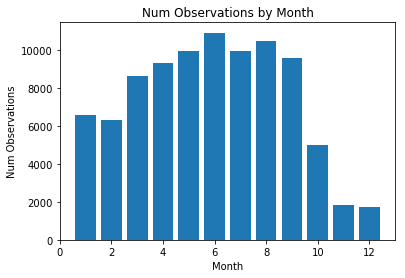

In [13]:
fig, ax = plt.subplots()
bar_width = 0.35

cols = npFloat_group_months
counts = list_group_train

barplot = plt.bar(cols, counts)
plt.xlabel('Month')
plt.ylabel('Num Observations')
plt.title('Num Observations by Month')


Summer months appear to be high times of selling. The last few months are skewed by fewer observations.

The next steps are a method to find variables that may be extreme or categorical.

In [14]:
numb_unique_per_col = train_df_filledna.T # Transpose the training dataset
numb_unique_per_col = numb_unique_per_col.apply(lambda x: x.nunique(), axis = 1) # Apply function to each column to get num of unique vals 
numb_unique_per_col.sort_values(0, ascending = True)

assessmentyear                      1
fips                                3
regionidcounty                      3
airconditioningtypeid               7
buildingqualitytypeid               9
unitcnt                            11
transaction_month                  12
heatingorsystemtypeid              13
propertylandusetypeid              14
fullbathcnt                        15
garagecarcnt                       16
bedroomcnt                         17
roomcnt                            17
bathroomcnt                        23
calculatedbathnbr                  23
propertycountylandusecode          77
yearbuilt                         131
regionidcity                      178
transactiondate                   352
regionidzip                       389
regionidneighborhood              495
garagetotalsqft                   871
logerror                         1894
propertyzoningdesc               1996
finishedsquarefeet12             4983
calculatedfinishedsquarefeet     5103
lotsizesquar

Three columns stand out here: assessmentyear, fips, and regionidcounty.

In [15]:
numb_unique_per_col[numb_unique_per_col == 1]

assessmentyear    1
dtype: int64

In [16]:
train_df_filledna = train_df_filledna.drop(['assessmentyear'],axis=1) # Only one value
train_df_filledna.shape

(90275, 34)

In [17]:
train_df_filledna.dtypes[train_df_filledna.dtypes != "float64"].index

Index(['transactiondate', 'propertycountylandusecode', 'propertyzoningdesc'], dtype='object')

In [18]:
train_df_filledna['propertycountylandusecode']
#found strings

parcelid
11016594    0100
14366692       1
12098116    0100
12643413    010C
14432541     122
11509835    0100
12286022    0100
17177301    1129
14739064      34
14677559      34
10854446    0100
11672170    0100
10949761    0100
14665244       1
14148540     122
14057104     122
17296797    1128
12524288    010E
14091502     122
10815909    0100
12453853    0100
14253461     122
14001034     122
11458863    0104
13957980     122
12752047    0100
11188425    0100
14646051      34
10805063    010E
12524725    010C
            ... 
10757551    0100
12558267    01HC
11710734    0100
14347592     122
11341061    0100
14027878     122
12756771    0100
12758333    010C
11295458    010C
12757889    0100
11308315    0100
14353215     122
10753416    010C
11756902    010C
11994047    010C
11440746    010C
11703478    0100
10965821    0100
12067066    010C
11683263    010C
12062080    010C
12265636    0200
17109680    1111
12268527    0100
12920746    0100
10774160    010C
12046695    0100
12995

In [19]:
train_df_filledna['propertycountylandusecode'].nunique()

77

In [20]:
train_df_filledna = train_df_filledna.drop(['propertycountylandusecode'],axis=1)
train_df_filledna.shape

(90275, 33)

In [21]:
train_df_filledna['propertyzoningdesc']

parcelid
11016594          LARS
14366692           NaN
12098116          PSR6
12643413          LAR3
14432541           NaN
11509835        HBR3YY
12286022         CORH*
17177301           NaN
14739064           NaN
14677559           NaN
10854446         LARE9
11672170          LAR1
10949761         BUR1*
14665244           NaN
14148540           NaN
14057104           NaN
17296797           NaN
12524288         LBR4R
14091502           NaN
10815909          LAR1
12453853         LBR1N
14253461           NaN
14001034           NaN
11458863          LAR1
13957980           NaN
12752047         LMR1*
11188425    PDRPD6.6U*
14646051           NaN
10805063          LAR3
12524725         LBR4N
               ...    
10757551          LAR1
12558267         LBPD6
11710734          LAR1
14347592           NaN
11341061     LCR17500*
14027878           NaN
12756771        NOR1YY
12758333     NOR1(R3)*
11295458    LRRPD75002
12757889        NOR1YY
11308315      LRR7000*
14353215           NaN
10

In [22]:
train_df_filledna['propertyzoningdesc'].nunique()

1996

In [23]:
train_df_filledna = train_df_filledna.drop(['propertyzoningdesc'], axis=1)
train_df_filledna.shape

(90275, 32)

In [24]:
numb_unique_per_col[numb_unique_per_col == 1]

assessmentyear    1
dtype: int64

In [25]:
train_df_filledna.columns.tolist()

['logerror',
 'transactiondate',
 'airconditioningtypeid',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'transaction_month']

In [26]:
numb_unique_per_col.sort_values(0, ascending = True)

assessmentyear                      1
fips                                3
regionidcounty                      3
airconditioningtypeid               7
buildingqualitytypeid               9
unitcnt                            11
transaction_month                  12
heatingorsystemtypeid              13
propertylandusetypeid              14
fullbathcnt                        15
garagecarcnt                       16
bedroomcnt                         17
roomcnt                            17
bathroomcnt                        23
calculatedbathnbr                  23
propertycountylandusecode          77
yearbuilt                         131
regionidcity                      178
transactiondate                   352
regionidzip                       389
regionidneighborhood              495
garagetotalsqft                   871
logerror                         1894
propertyzoningdesc               1996
finishedsquarefeet12             4983
calculatedfinishedsquarefeet     5103
lotsizesquar

In [27]:
train_df_filledna = train_df_filledna.drop(['censustractandblock','regionidcounty','regionidcity','regionidzip','regionidneighborhood','transactiondate'], axis=1)

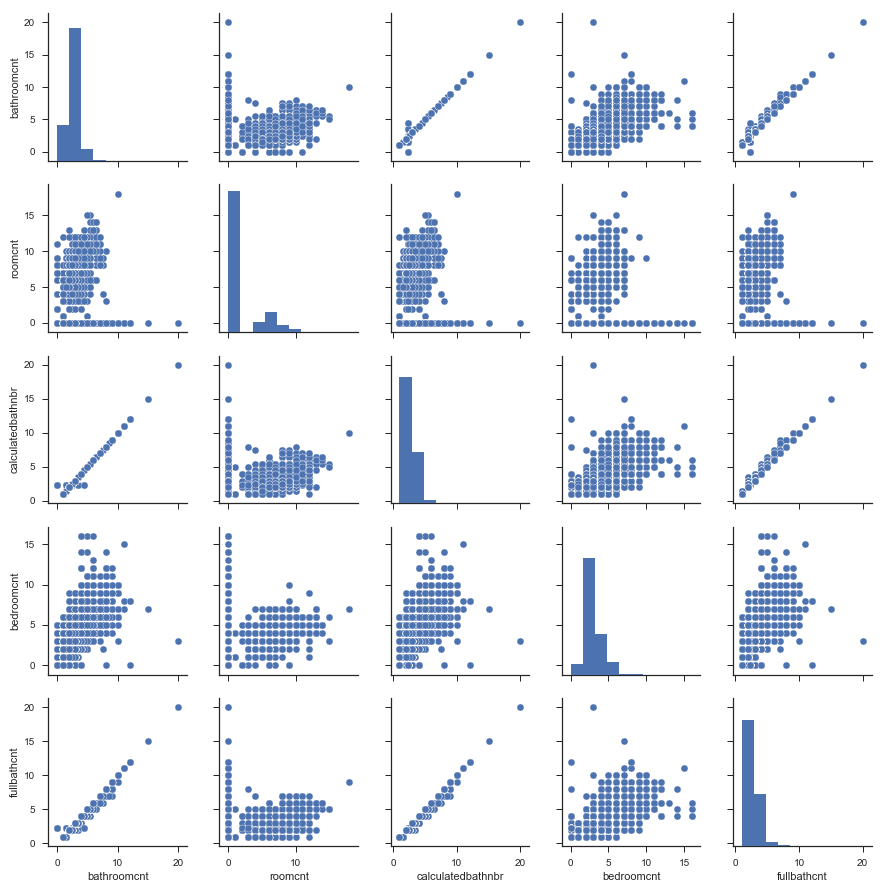

In [28]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(train_df_filledna[['bathroomcnt','roomcnt','calculatedbathnbr','bedroomcnt','fullbathcnt']])

In [29]:
train_df_filledna = train_df_filledna.drop(['bathroomcnt','fullbathcnt'], axis=1) # Too correlated

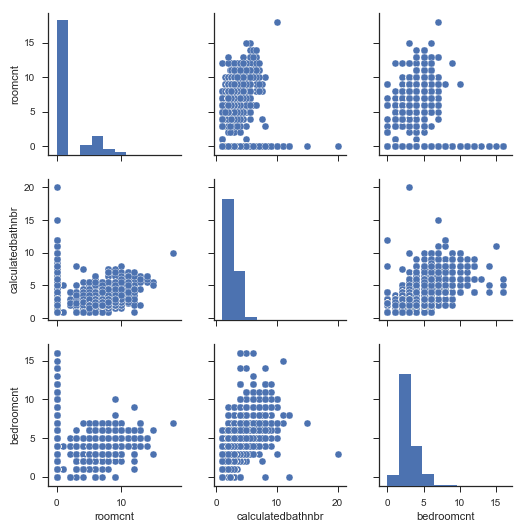

In [30]:
sns.pairplot(train_df_filledna[['roomcnt','calculatedbathnbr','bedroomcnt']])

### The 3 vars are not too correlated to require removal

In [31]:
train_df_filledna.columns.tolist()

['logerror',
 'airconditioningtypeid',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'garagecarcnt',
 'garagetotalsqft',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'transaction_month']

In [32]:
print("Variables remaining: ",train_df_filledna.shape[1])

Variables remaining:  24


In [33]:
train_df2 = train_df_filledna

In [34]:
missing_df2 = train_df2.isnull().sum(axis=0).reset_index()
missing_df2.columns = ['count', 'val']
missing_df2[missing_df2['val'] > 0]
# Should be empty because we removed all NaN vals

,count,val


In [35]:
train_df2.head()

,logerror,airconditioningtypeid,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,garagecarcnt,garagetotalsqft,...,propertylandusetypeid,rawcensustractandblock,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,transaction_month
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,1.0000,3.0000,4.0000,2.0000,"1,684.0000","1,684.0000","6,037.0000",1.8120,345.5212,...,261.0000,"60,371,066.4610",0.0000,1.0000,"1,959.0000","122,754.0000","360,170.0000","237,416.0000","6,735.8800",1.0000
14366692,-0.1684,1.8164,4.0000,5.5654,3.5000,"2,263.0000","2,263.0000","6,059.0000",2.0000,468.0000,...,261.0000,"60,590,524.2220",0.0000,1.1104,"2,014.0000","346,458.0000","585,529.0000","239,071.0000","10,153.0200",1.0000
12098116,-0.0040,1.0000,2.0000,4.0000,3.0000,"2,217.0000","2,217.0000","6,037.0000",1.8120,345.5212,...,261.0000,"60,374,638.0030",0.0000,1.0000,"1,940.0000","61,994.0000","119,906.0000","57,912.0000","11,484.4800",1.0000
12643413,0.0218,1.0000,2.0000,4.0000,2.0000,839.0000,839.0000,"6,037.0000",1.8120,345.5212,...,266.0000,"60,372,963.0020",0.0000,1.0000,"1,987.0000","171,518.0000","244,880.0000","73,362.0000","3,048.7400",1.0000
14432541,-0.0050,1.8164,4.0000,5.5654,2.5000,"2,283.0000","2,283.0000","6,059.0000",2.0000,598.0000,...,261.0000,"60,590,423.3810",8.0000,1.1104,"1,981.0000","169,574.0000","434,551.0000","264,977.0000","5,488.9600",1.0000


### Dealing with categorical variables

In [36]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
one_hot_colnames_before = ["airconditioningtypeid", 
                    "heatingorsystemtypeid", "propertylandusetypeid"]

In [38]:
train_df2.groupby(by=['airconditioningtypeid']).logerror.count().reset_index()

,airconditioningtypeid,logerror
0,1.0000,26668
1,1.8164,61494
2,3.0000,1
3,5.0000,215
4,9.0000,1
5,11.0000,63
6,13.0000,1833


In [39]:
train_df2['airConditionFlag'] = np.ceil(train_df2.airconditioningtypeid).apply(lambda x: 1 if x ==2.0 else 0)

In [40]:
train_df2.airConditionFlag.mean()

0.681185267238992

In [41]:
train_df2.groupby(by=['airConditionFlag']).logerror.count().reset_index()

,airConditionFlag,logerror
0,0,28781
1,1,61494


In [42]:
train_df2.drop(['airconditioningtypeid'],inplace=True,axis=1)
train_df2.columns.tolist()

['logerror',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'garagecarcnt',
 'garagetotalsqft',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'transaction_month',
 'airConditionFlag']

In [43]:
train_df2.groupby(by=['heatingorsystemtypeid']).logerror.count().reset_index()

,heatingorsystemtypeid,logerror
0,1.0000,13
1,2.0000,38303
2,3.9270,34195
3,6.0000,970
4,7.0000,15519
5,10.0000,2
6,11.0000,1
7,12.0000,1
8,13.0000,76
9,14.0000,2


In [44]:
train_df2['heatingSystemNew'] = np.ceil(train_df2.heatingorsystemtypeid).apply(lambda x: 1 if x == 4.0 else 0)

In [45]:
train_df2.heatingSystemNew.mean()

0.3787870396012185

In [46]:
train_df2.groupby(by=['heatingSystemNew']).logerror.count().reset_index()

,heatingSystemNew,logerror
0,0,56080
1,1,34195


In [47]:
train_df2.drop(['heatingorsystemtypeid'],inplace=True,axis=1)
train_df2.columns.tolist()

['logerror',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'garagecarcnt',
 'garagetotalsqft',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'transaction_month',
 'airConditionFlag',
 'heatingSystemNew']

In [48]:
train_df2.head()

,logerror,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,garagecarcnt,garagetotalsqft,latitude,...,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,transaction_month,airConditionFlag,heatingSystemNew
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,3.0000,4.0000,2.0000,"1,684.0000","1,684.0000","6,037.0000",1.8120,345.5212,"34,280,990.0000",...,0.0000,1.0000,"1,959.0000","122,754.0000","360,170.0000","237,416.0000","6,735.8800",1.0000,0,0
14366692,-0.1684,4.0000,5.5654,3.5000,"2,263.0000","2,263.0000","6,059.0000",2.0000,468.0000,"33,668,120.0000",...,0.0000,1.1104,"2,014.0000","346,458.0000","585,529.0000","239,071.0000","10,153.0200",1.0000,1,1
12098116,-0.0040,2.0000,4.0000,3.0000,"2,217.0000","2,217.0000","6,037.0000",1.8120,345.5212,"34,136,312.0000",...,0.0000,1.0000,"1,940.0000","61,994.0000","119,906.0000","57,912.0000","11,484.4800",1.0000,0,0
12643413,0.0218,2.0000,4.0000,2.0000,839.0000,839.0000,"6,037.0000",1.8120,345.5212,"33,755,800.0000",...,0.0000,1.0000,"1,987.0000","171,518.0000","244,880.0000","73,362.0000","3,048.7400",1.0000,0,0
14432541,-0.0050,4.0000,5.5654,2.5000,"2,283.0000","2,283.0000","6,059.0000",2.0000,598.0000,"33,485,643.0000",...,8.0000,1.1104,"1,981.0000","169,574.0000","434,551.0000","264,977.0000","5,488.9600",1.0000,1,1


# Change code to not scale the categorical variables 20171016 

## Flooring and Capping 

In [49]:
train_y = train_df2['logerror']

In [50]:
ceil_y = train_y.quantile(q= 0.95)
floor_y = train_y.quantile(q=0.05)

In [51]:
print(train_y.quantile(q=0.05))
print(train_y.quantile(q=0.95))


-0.1267
0.1647


In [52]:
train_df2['logerror'].describe()

count   90,275.0000
mean         0.0115
std          0.1611
min         -4.6050
25%         -0.0253
50%          0.0060
75%          0.0392
max          4.7370
Name: logerror, dtype: float64

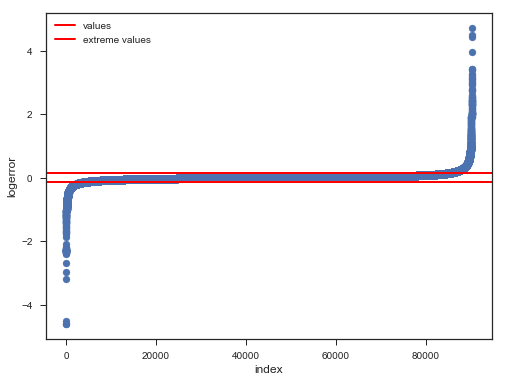

In [53]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df2['logerror'].size), np.sort(train_df2['logerror']))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.axhline(y = ceil_y, linewidth = 2, color = 'r')
plt.axhline(y = floor_y, linewidth = 2, color = 'r')
plt.legend(['values', 'extreme values'])
plt.show()

In [54]:
train_y[train_y > ceil_y] = ceil_y
train_y[train_y < floor_y] = floor_y

C:\Users\board\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\board\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


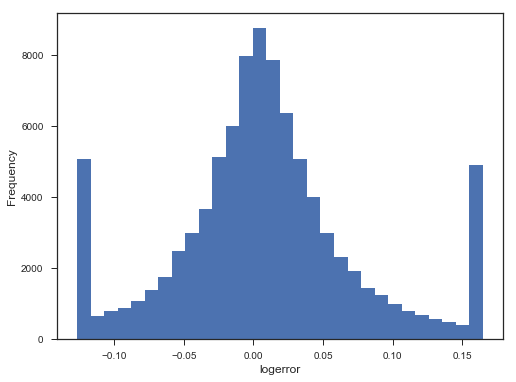

In [55]:
plt.figure(figsize=(8,6))
plt.hist(train_y, bins = 30)
plt.xlabel('logerror', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

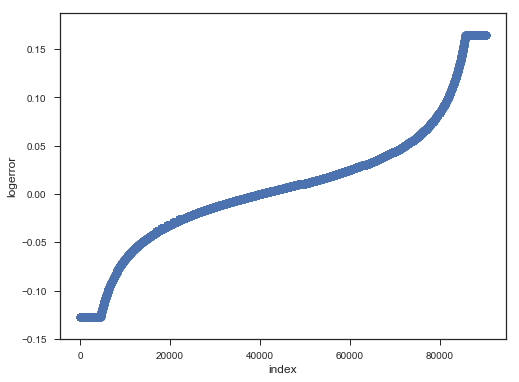

In [56]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_y.size), np.sort(train_y))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

In [57]:
print("Min value: ",min(train_y))
print("Max value: ", max(train_y)) 

Min value:  -0.1267
Max value:  0.1647


### Last minute variable drops 

In [58]:
train_df2.drop(['transaction_month', 'taxamount', 'finishedsquarefeet12'], axis = 1, inplace = True)

In [59]:
train_df2.columns

Index(['logerror', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'garagecarcnt',
       'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertylandusetypeid', 'rawcensustractandblock', 'roomcnt', 'unitcnt',
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'airConditionFlag', 'heatingSystemNew'],
      dtype='object')

### Scale Data

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [61]:
scaler = StandardScaler().fit(train_df2.drop(['logerror'],axis = 1))

In [62]:
train_df3 = scaler.transform(train_df2.drop(['logerror'], axis =1))
train_df3.shape

(90275, 20)

In [63]:
train_df4 = pd.DataFrame(train_df3,columns=train_df2.drop(['logerror'],axis = 1).columns,index=train_df2.index)
train_df4['logerror'] = train_df2['logerror']
train_df4.head()

,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,...,rawcensustractandblock,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,airConditionFlag,heatingSystemNew,logerror
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,-0.0276,-1.0332,-0.3189,-0.0964,-0.5745,-0.0000,0.0000,1.0401,-0.8033,-0.1882,...,-0.5888,-0.5244,-0.1723,-0.4028,-0.2748,-0.1757,-0.1022,-1.4617,-0.7809,0.0276
14366692,0.8372,0.0000,1.2279,0.5297,0.4902,0.5363,0.7965,-1.2730,1.4457,-0.2221,...,0.4815,-0.5244,0.0000,1.9214,0.7972,0.2304,-0.0980,0.6841,1.2806,-0.1267
12098116,-0.8923,-1.0332,0.7123,0.4799,-0.5745,-0.0000,0.0000,0.4940,0.0661,-0.1542,...,-0.5713,-0.5244,-0.1723,-1.2058,-0.5659,-0.6087,-0.5504,-1.4617,-0.7809,-0.0040
12643413,-0.8923,-1.0332,-0.3189,-1.0102,-0.5745,-0.0000,0.0000,-0.9421,-0.3054,0.3641,...,-0.5795,-0.5244,-0.1723,0.7804,-0.0411,-0.3835,-0.5118,-1.4617,-0.7809,0.0218
14432541,0.8372,0.0000,0.1967,0.5513,0.4902,0.5363,1.6420,-1.9617,1.3828,-0.2015,...,0.4810,2.3129,0.0000,0.5268,-0.0504,-0.0417,-0.0334,0.6841,1.2806,-0.0050


## Linear Regression

### Start by splitting into test train set 

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X = train_df4.drop(['logerror'], axis = 1)
y = train_y

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [67]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(90275, 20)
(90275,)
(67706, 20)
(22569, 20)
(67706,)
(22569,)


In [68]:
import statsmodels.api as sm

In [69]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     26.17
Date:                Mon, 16 Oct 2017   Prob (F-statistic):           9.45e-98
Time:                        23:41:03   Log-Likelihood:                 87275.
No. Observations:               67706   AIC:                        -1.745e+05
Df Residuals:                   67686   BIC:                        -1.743e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bedroomcnt      

In [70]:
results.params[abs(results.params) > 0.02]

fips                          0.0761
rawcensustractandblock       -0.0739
structuretaxvaluedollarcnt   -0.0291
taxvaluedollarcnt             0.0691
landtaxvaluedollarcnt        -0.0505
dtype: float64

In [71]:
results.pvalues[results.pvalues < 0.05]

bedroomcnt                     0.0366
calculatedfinishedsquarefeet   0.0000
fips                           0.0052
latitude                       0.0457
lotsizesquarefeet              0.0307
rawcensustractandblock         0.0065
unitcnt                        0.0393
structuretaxvaluedollarcnt     0.0000
taxvaluedollarcnt              0.0000
landtaxvaluedollarcnt          0.0000
dtype: float64

In [72]:
print("Number of variables without pvalue issues: ", len(results.pvalues[results.pvalues < 0.05]))
print("Number of variables with relatively significant coefficients: ", len(results.params[abs(results.params) > 0.02]))

Number of variables without pvalue issues:  10
Number of variables with relatively significant coefficients:  5


## Examine Validation Set 

In [73]:
test_pred = results.predict(X_test)

In [74]:
from sklearn.metrics import r2_score, mean_absolute_error, roc_auc_score, roc_curve

In [75]:
r2_dev = r2_score(y_train, results.fittedvalues)
r2_dev

-0.0094743071841407733

In [76]:
r2_itv = r2_score(y_test, test_pred)
r2_itv

-0.0067370491536273835

In [77]:
(r2_dev/r2_itv - 1)*100

40.629925180812833

In [78]:
mean_absolute_error(y_test, test_pred)

0.04851283013014257

In [79]:
# Scaled mae 
(mean_absolute_error(y_test, test_pred)/y_test.shape)

array([  2.14953388e-06])

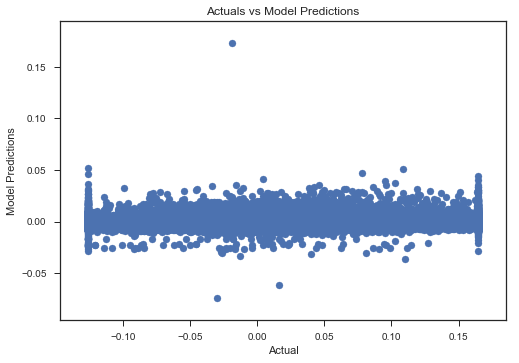

In [80]:
plt.scatter(y_test, test_pred)
plt.xlabel("Actual")
plt.ylabel("Model Predictions")
plt.title("Actuals vs Model Predictions")


In [81]:
results = pd.DataFrame(data = {"y_test": y_test, "test_pred": test_pred})

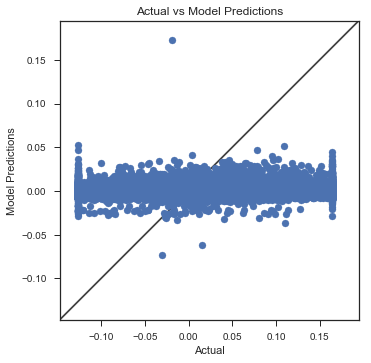

In [82]:
fig, ax = plt.subplots()
ax.scatter(results.y_test[abs(results.test_pred) < 0.25], results.test_pred[abs(results.test_pred) < 0.25])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.xlabel("Actual")
plt.ylabel("Model Predictions")
plt.title("Actual vs Model Predictions")

In [83]:
#sns.pairplot(train_df4)

### Submission Steps

We will want to make the dataset as similar to the training set as possible before running the predictive steps  
* We will have to drop the variables that had too many missing training examples
* Create the flags for the variables we made flags for 
* Potentially work with the date time column 
* Run through the standard scaler 
* Finally, run through the predictive algorithm 

In [84]:
train_df_new = pd.read_csv("train_2016_v2.csv")
test = pd.read_csv("sample_submission.csv")
prop = pd.read_csv("properties_2016.csv")

C:\Users\board\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [85]:
train_df_new.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [86]:
test.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


In [87]:
prop.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,nan,nan,nan,0.0000,0.0000,nan,nan,nan,nan,...,nan,NaN,nan,9.0000,"2,015.0000",9.0000,nan,NaN,nan,nan
1,10759547,nan,nan,nan,0.0000,0.0000,nan,nan,nan,nan,...,nan,NaN,nan,"27,516.0000","2,015.0000","27,516.0000",nan,NaN,nan,nan
2,10843547,nan,nan,nan,0.0000,0.0000,nan,nan,nan,nan,...,nan,NaN,"650,756.0000","1,413,387.0000","2,015.0000","762,631.0000","20,800.3700",NaN,nan,nan
3,10859147,nan,nan,nan,0.0000,0.0000,3.0000,7.0000,nan,nan,...,1.0000,NaN,"571,346.0000","1,156,834.0000","2,015.0000","585,488.0000","14,557.5700",NaN,nan,nan
4,10879947,nan,nan,nan,0.0000,0.0000,4.0000,nan,nan,nan,...,nan,NaN,"193,796.0000","433,491.0000","2,015.0000","239,695.0000","5,725.1700",NaN,nan,nan


Create the master test set by combining parcelid's specified in the submission file with the parcel id from the properties file  

We want to change the ParcelId from the test set to match the parcelid column from the properties file.  
Without changing it, they will not match correctly 

In [88]:
test['parcelid'] = test['ParcelId']
df_test = test.merge(prop, on='parcelid', how = 'left') 
print("Test DF len: " ,len(df_test))
print("Input DF len: ", len(test))

Test DF len:  2985217
Input DF len:  2985217


In [89]:
df_test.head()

,ParcelId,201610,201611,201612,201710,201711,201712,parcelid,airconditioningtypeid,architecturalstyletypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,0,0,0,0,0,0,10754147,nan,nan,...,nan,NaN,nan,9.0000,"2,015.0000",9.0000,nan,NaN,nan,nan
1,10759547,0,0,0,0,0,0,10759547,nan,nan,...,nan,NaN,nan,"27,516.0000","2,015.0000","27,516.0000",nan,NaN,nan,nan
2,10843547,0,0,0,0,0,0,10843547,nan,nan,...,nan,NaN,"650,756.0000","1,413,387.0000","2,015.0000","762,631.0000","20,800.3700",NaN,nan,nan
3,10859147,0,0,0,0,0,0,10859147,nan,nan,...,1.0000,NaN,"571,346.0000","1,156,834.0000","2,015.0000","585,488.0000","14,557.5700",NaN,nan,nan
4,10879947,0,0,0,0,0,0,10879947,nan,nan,...,nan,NaN,"193,796.0000","433,491.0000","2,015.0000","239,695.0000","5,725.1700",NaN,nan,nan


Start by dropping variables that had too many missing values in the training set 

In [90]:
df_test1 = df_test.drop(missing_df_over75.column_name.tolist(), axis = 1)

Impute mean for the missing NAs, we will use the means previously found from the training set  

In [91]:
df_test_filled_na = df_test1.fillna(mean_values, inplace=True)

Drop more columns  
Create flag variable for missing observations 

In [92]:
df_test2 = df_test_filled_na.drop(['censustractandblock','regionidcounty',
                        'regionidcity','regionidzip','regionidneighborhood',
                         'assessmentyear' , 'propertycountylandusecode',
                        'propertyzoningdesc', 'bathroomcnt','fullbathcnt', 'ParcelId',
                        'airconditioningtypeid', 'finishedsquarefeet12', 'heatingorsystemtypeid',
                        'taxamount'], axis=1)
df_test2.index = df_test2.parcelid
df_test2.drop(['parcelid'], axis =1, inplace= True )
#####
# TODO implement logic from below 
#####
df_test2['heatingSystemNew'] = 1
df_test2['airConditionFlag'] = 0
#df_test2['heatingSystemNew'] = np.ceil(df_test_filled_na.heatingorsystemtypeid).apply(lambda x: 1 if x == 4.0 else 0)
#df_test2['airConditionFlag'] = np.ceil(df_test_filled_na.airconditioningtypeid).apply(lambda x: 1 if x == 2.0 else 0)

Check if datasets have the same variables 

In [93]:
df_test2.shape

(2985217, 26)

In [94]:
train_df4.shape

(90275, 21)

In [95]:
df_test2.columns

Index(['201610', '201611', '201612', '201710', '201711', '201712',
       'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'garagecarcnt',
       'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertylandusetypeid', 'rawcensustractandblock', 'roomcnt', 'unitcnt',
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'heatingSystemNew', 'airConditionFlag'],
      dtype='object')

In [96]:
train_df4.columns

Index(['bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'garagecarcnt',
       'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertylandusetypeid', 'rawcensustractandblock', 'roomcnt', 'unitcnt',
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'airConditionFlag', 'heatingSystemNew',
       'logerror'],
      dtype='object')

In [97]:
cols = []
for column in df_test2.columns:
    if column not in train_df4.columns:
        print(column)
        cols.append(column)


201610
201611
201612
201710
201711
201712


In [98]:
for column in train_df4.columns:
    if column not in df_test2.columns:
        print(column)

logerror


In [99]:
df_test_pred = df_test2.drop(cols, axis=1)

In [100]:
df_test_pred.columns

Index(['bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'garagecarcnt',
       'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertylandusetypeid', 'rawcensustractandblock', 'roomcnt', 'unitcnt',
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'heatingSystemNew', 'airConditionFlag'],
      dtype='object')

Scale the test dataset using the same parameters as the training dataset 

In [101]:
scaled_test_df = scaler.transform(df_test_pred)

### Use Linear Regression Model to create predictions 

In [113]:
predictions = model.fit().predict(scaled_test_df)

### Begin preparing submission file  

In [117]:
sub = pd.read_csv("sample_submission.csv")
# Put the same prediction in all the columns
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = predictions

In [115]:
# Export to csv 
sub.to_csv('LinearRegression.csv', index=False, float_format='%.4f')

In [116]:
sub.shape
# Should be 7 -- 6 time periods and 1 parcel ID 

(2985217, 7)